In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [10]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(16.7, 20.873214285714287, 23.3)]


In [11]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
trip = "2017-08-01 to \n 2017-08-07"
trip_start = "2017-08-01"
trip_end = "2017-08-07"
trip_temps = calc_temps(trip_start, trip_end)
trip_temps

[(22.2, 26.25, 28.3)]

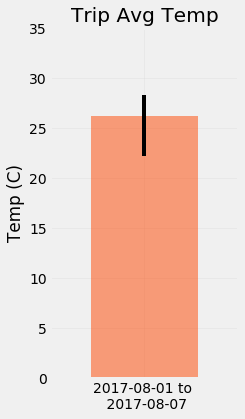

In [12]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_trip_temp = trip_temps[0][0]
avg_trip_temp = trip_temps[0][1]
max_trip_temp = trip_temps[0][2]

min_error = avg_trip_temp - min_trip_temp
max_error = max_trip_temp - avg_trip_temp

error_bars = np.array([[min_error], [max_error]])

plt.figure(figsize=(3,6))
plt.bar(trip, avg_trip_temp, yerr=error_bars, color = "orangered", alpha = .5)
plt.ylim(0, 35)
plt.xlim(-.7, .7)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (C)")
plt.grid(alpha=.2)

### Daily Rainfall Average

In [13]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


### Daily Temperature Normals

In [14]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(16.7, 20.64230769230769, 25.0)]

In [15]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = "2017-08-01"
end_date = "2017-08-07"

# Use the start and end date to create a range of dates
start_num = int(start_date[-2:])
end_num = int(end_date[-2:])
trip_length = end_num - start_num + 1

# Strip off the year and save a list of strings in the format %m-%d
start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
date_list = [dt.datetime.strftime(start_date + dt.timedelta(days = x), "%m-%d") 
            for x in range(0, trip_length)]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
trip_normals = [daily_normals(date) for date in date_list]
trip_normals = [np.array(normal[0]) for normal in trip_normals]


In [16]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(trip_normals)
normals_df["Date"] = date_list
normals_df = normals_df.set_index("Date")
normals_df = normals_df.rename(columns={0: "tmin", 1: "tavg", 2: "tmax"})
normals_df

,tmin,tavg,tmax
Date,,,
08-01,19.4,24.186000,28.3
08-02,20.0,24.220755,28.9
08-03,21.1,24.777778,29.4
08-04,20.6,24.840385,28.9
08-05,20.6,24.529630,27.8
08-06,19.4,24.582143,28.3
08-07,21.7,25.082353,28.3


Text(0, 0.5, 'Temperature')

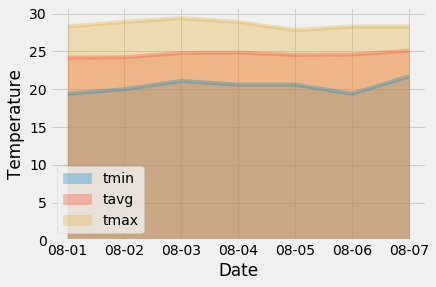

In [17]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, alpha=.333)
plt.ylabel("Temperature")

## Close Session

In [18]:
session.close()